# Fabric Data Validation (Part 1 of 2) 
#### Using Great Expectations - a python library for data validation and testing
This notebook sets up Great Expectations to be used for data validation of Fabric Lakehouse tables between Bronze and Silver. 

We build up the configuration (the Data Context) interactively and progressively, before copying it to a Fabric Lakehouse Files location for persistence. 

This only needs to be once. There is another notebook to perform the validation on all new data (based on the configuration we describe in this notebook.)

#### Reminder of the medallion architecture:
![Medallation architecture](https://miro.medium.com/v2/resize:fit:1158/1*26s4vihaKxxwqAomwNAczw.png)


# Avoid this 👇
- It will cost you more money (will have to reinstall every time the pipeline/ notebook runs)
- Does not control the python package version, which could lead to pipeline failures  when the package updates 

In [1]:
# DON'T DO THIS
#!pip install great_expectations 

StatementMeta(, 419616f5-ab45-4b25-a5ee-b9c425b85e69, 5, Finished, Available)

  Obtaining dependency information for jupyter-server<3,>=2.4.0 from https://files.pythonhosted.org/packages/28/d9/4bf2ab8410cdc37f54aadb6cae497b9bc8ae16720d97b762b9bfb7834022/jupyter_server-2.7.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.3/375.3 kB 30.6 MB/s eta 0:00:00
DEPRECATION: notebookutils 3.3.0-20230703.1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of notebookutils or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: send2trash
    Found existing installation: Send2Trash 1.8.0
    Uninstalling Send2Trash-1.8.0:
      Successfully uninstalled Send2Trash-1.8.0
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter_server 2.2.1
    Uninstalling jupyter_server-2.2.1:
      Successfully uninstalled jupyt

#### Instead, use Library Management in Workspace Settings
- All team members using the same version of a package
- All notebooks in your workspace using the same version of the 


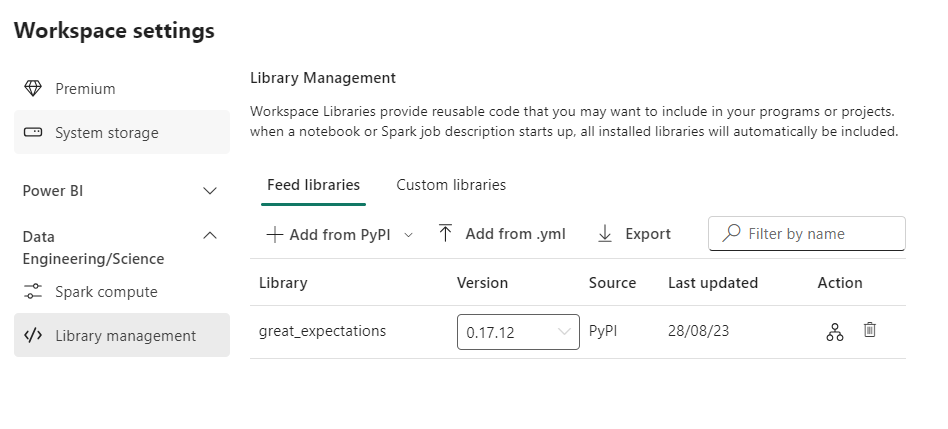

## Settings up Great Expectations

In [2]:
# import great_expectations using workspace settings -> Library Management 😎
import great_expectations as gx

# initialise the gx context
context = gx.get_context()

# add an (empty) expectation suite 
context.add_or_update_expectation_suite("my_expectation_suite")


StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 6, Finished, Available)

Created temporary directory '/tmp/tmpe767wpkk' for ephemeral docs site


{
  "expectation_suite_name": "my_expectation_suite",
  "ge_cloud_id": null,
  "expectations": [],
  "data_asset_type": null,
  "meta": {
    "great_expectations_version": "0.17.12"
  }
}

#### Prepare the batch request

In [3]:
# declare a spark source as a datasource
datasource = context.sources.add_spark("my_spark_datasource")

# declare a data asset   
data_asset = datasource.add_dataframe_asset("my_df_asset")

# prepare a Spark Dataframe
bronze_dataframe = spark.sql("SELECT * FROM TutorialLakehouse.historic_weather_data LIMIT 1000")

# build a batch request, passing in the dataframe
my_batch_request = data_asset.build_batch_request(dataframe=bronze_dataframe)


StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 7, Finished, Available)

#### Prepare the Expectation Suite
<img src="https://docs.greatexpectations.io/assets/images/where_expectations_come_from-d848fe00a77ae738a3e3d053e128474e.png" alt="Where to expectations come from?" width="600" height="500">


#### Create the validator

In [4]:
validator = context.get_validator(
    batch_request=my_batch_request,
    expectation_suite_name="my_expectation_suite",
)
validator.expect_column_values_to_not_be_null(column='datetime')
validator.expect_column_values_to_not_be_null(column='temperature_kelvin')
validator.expect_column_values_to_not_be_null(column='temperature_degrees')
validator.expect_column_values_to_not_be_null(column='temperature_fahrenheit')
validator.save_expectation_suite(discard_failed_expectations=False)

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 8, Finished, Available)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/great_expectations/expectations/expectation.py:1479: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

#### Adding checkpoints

In [5]:
my_checkpoint_name = "my_checkpoint"

yaml_config = f"""
name: {my_checkpoint_name}
config_version: 1.0
class_name: SimpleCheckpoint
run_name_template: "%Y%m%d-%H%M%S-my-run-name-template"
validations:
  - batch_request:
      datasource_name: my_spark_datasource
      data_asset_name: my_df_asset
expectation_suite_name: my_expectation_suite
"""

# test the YAML config file above 
my_checkpoint = context.test_yaml_config(yaml_config=yaml_config)

#add the checkpoint to our context
context.add_checkpoint(checkpoint=my_checkpoint)

#run the checkpoint and store the results 
checkpoint_run_result = context.run_checkpoint(
    checkpoint_name="my_checkpoint",
)

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 13, Finished, Available)

Attempting to instantiate class from config...
	Instantiating as a SimpleCheckpoint, since class_name is SimpleCheckpoint
	Successfully instantiated SimpleCheckpoint


Checkpoint class name: SimpleCheckpoint


Calculating Metrics:   0%|          | 0/28 [00:00<?, ?it/s]

In [6]:
checkpoint_run_result

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 15, Finished, Available)

{
  "run_id": {
    "run_name": "20230828-130938-my-run-name-template",
    "run_time": "2023-08-28T13:09:38.458591+00:00"
  },
  "run_results": {
    "ValidationResultIdentifier::my_expectation_suite/20230828-130938-my-run-name-template/20230828T130938.458591Z/my_spark_datasource-my_df_asset": {
      "validation_result": {
        "success": true,
        "results": [
          {
            "success": true,
            "expectation_config": {
              "expectation_type": "expect_column_values_to_not_be_null",
              "kwargs": {
                "column": "datetime",
                "batch_id": "my_spark_datasource-my_df_asset"
              },
              "meta": {}
            },
            "result": {
              "element_count": 16,
              "unexpected_count": 0,
              "unexpected_percent": 0.0,
              "partial_unexpected_list": [],
              "partial_unexpected_counts": []
            },
            "meta": {},
            "exception_info

In [27]:
!cp -r great_expectations/ /lakehouse/default/Files/


StatementMeta(, edbff1f4-eebe-4e23-bfe5-ebd700e1b613, 36, Finished, Available)

## Run the validation on new data/ from configuration files 

In [11]:
from great_expectations.data_context import FileDataContext

path_to_local_context = '/lakehouse/default/Files'

# initialise the data context from the Lakehouse Files
context = FileDataContext.create(project_root_dir=path_to_local_context)

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 20, Finished, Available)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/great_expectations/data_context/data_context/serializable_data_context.py:223: UserWarning: Warning. An existing `great_expectations.yml` was found here: /lakehouse/default/Files/great_expectations.
    - No action was taken.
  warnings.warn(message)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/great_expectations/data_context/data_context/serializable_data_context.py:235: UserWarning: Warning. An existing `config_variables.yml` was found here: /lakehouse/default/Files/great_expectations/uncommitted.
    - No action was taken.
  warnings.warn(message)



#### Get fresh data to test and send to a batch request

In [22]:
# get a fresh load of data
bronze_dataframe = spark.sql("SELECT * FROM TutorialLakehouse.historic_weather_data LIMIT 1000")

# get my data asset from the data context
my_asset = context.get_datasource("my_spark_datasource").get_asset("my_df_asset")

# create a new batch request from the new data
my_asset.build_batch_request(dataframe=bronze_dataframe)

# run the checkpoint again
results = context.run_checkpoint(checkpoint_name="my_checkpoint")

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 31, Finished, Available)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(



Calculating Metrics:   0%|          | 0/28 [00:00<?, ?it/s]

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 32, Finished, Available)

## Handle Results
- log the results in a log table
- if success, write to Silver Table
- if failure, 

In [23]:
results

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 33, Finished, Available)

{
  "run_id": {
    "run_name": "20230828-134623-my-run-name-template",
    "run_time": "2023-08-28T13:46:23.723199+00:00"
  },
  "run_results": {
    "ValidationResultIdentifier::my_expectation_suite/20230828-134623-my-run-name-template/20230828T134623.723199Z/my_spark_datasource-my_df_asset": {
      "validation_result": {
        "success": true,
        "results": [
          {
            "success": true,
            "expectation_config": {
              "expectation_type": "expect_column_values_to_not_be_null",
              "kwargs": {
                "column": "datetime",
                "batch_id": "my_spark_datasource-my_df_asset"
              },
              "meta": {}
            },
            "result": {
              "element_count": 16,
              "unexpected_count": 0,
              "unexpected_percent": 0.0,
              "partial_unexpected_list": [],
              "partial_unexpected_counts": []
            },
            "meta": {},
            "exception_info

In [25]:
displayHTML('/lakehouse/default/Files/great_expectations/uncommitted/data_docs/local_site/validations/my_expectation_suite/20230828-134623-my-run-name-template/20230828T134623.723199Z/my_spark_datasource-my_df_asset.html')

StatementMeta(, 05932f19-f8ca-4b4e-b6e5-9f128d275244, 35, Finished, Available)

,
Evaluated Expectations,4
Successful Expectations,4
Unsuccessful Expectations,0
Success Percent,100%
,
Great Expectations Version,0.17.12
Run Name,20230828-134623-my-run-name-template
Run Time,2023-08-28T13:46:23Z
,
ge_load_time,20230828T134624.014746Z
